In [392]:
# !git clone https://github.com/Jsrsky/machine_unlearning_experiments
# %cd machine_unlearning_experiments/experiments/mnist/influence
# !pip install loguru

## Dependecies

In [393]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

In [394]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import numpy as np
from loguru import logger

## Utils 

In [395]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [396]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.resnet50 import load_model_resnet50, init_model_resnet50

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# # Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [397]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [398]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [399]:
BATCH_SIZE = 128
MINI_BATCH_SIZE = 1024

EPS = 1000
MAX_NORM = 10 #0.5
CG_ITERS = 5
SCALE = 1e3

# CALL FISHER

### Files

In [400]:
model_file = project_root / 'experiments/cifar10/naive/ResNet50_CIFAR10_model.pth'
samples_to_unlearn_file = project_root / 'experiments/cifar10/naive/cifar10_samples_to_unlearn_30per.json'
remaining_dataset_file = project_root / 'experiments/cifar10/naive/updated_cifar10_data_splits.json'

### Init models

In [401]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_resnet50(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = 'influence_' + original_model_name

import torch.nn as nn
model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])

Load model...
Init model...
Done initializing model.
Model ID: 140665161674096, Optimizer ID: 140665161675008, Criterion ID: 140665161673856
Done loading model.


## Init data

In [402]:
train_dataset = datasets.CIFAR10(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=data_root, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [403]:
from methods.fisher.fisher_utils import create_unlearning_dataloader

In [404]:
unlearn_indices, unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

In [405]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset), 
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

### TUTAJ COS

In [406]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()
import math

def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ = (1/|D_u|) Σ_{(x,y) in D_u} ∇_θ L(θ, (x,y))
    over the dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    
    grad_dict = {name: torch.zeros_like(param, device=DEVICE)
                 for name, param in model.named_parameters() if param.requires_grad}
    
    total_samples = 0

    model.train()  # ensure gradients are computed
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        with autocast(device_type=str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
        scaler.scale(loss).backward()
        
        current_batch = inputs.size(0)
        total_samples += current_batch

        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                grad_dict[name] += param.grad.detach().clone() * current_batch
        
        # for name, param in model.named_parameters():
        #     if param.requires_grad and param.grad is not None:
        #         if name not in grad_dict:
        #             grad_dict[name] = param.grad.detach().clone() * current_batch
        #         else:
        #             grad_dict[name] += param.grad.detach().clone() * current_batch

    # Average over total samples
    for name in grad_dict:
        grad_dict[name] /= total_samples

    # Flatten all gradients into one vector
    grad_vector = torch.cat([grad_dict[name].view(-1) for name in sorted(grad_dict.keys())])
    return grad_vector

def lissa_inverse_hvp(model, criterion, data_loader, v, damping=EPS, scale=SCALE, recursion_depth=20):
    ihvp_estimate = v.clone().to(DEVICE)
    data_iter = iter(data_loader)
    model.train()

    for _ in trange(recursion_depth, desc="LiSSA iterations", leave=False):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        with autocast(device_type=str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)

        hv = torch.autograd.grad(torch.dot(grad_vector, ihvp_estimate), model.parameters(), retain_graph=False)
        hv_vector = torch.cat([h.reshape(-1) for h in hv])

        # LiSSA recursive update
        ihvp_estimate = v + (1 - damping) * ihvp_estimate - hv_vector / scale

    return ihvp_estimate / scale


def lissa_inverse_hvp(model, criterion, data_loader, v, damping=EPS, scale=SCALE, recursion_depth=20):
    ihvp_estimate = v.clone().to(DEVICE)
    data_iter = iter(data_loader)
    model.train()

    for step in trange(recursion_depth, desc="LiSSA iterations", leave=False):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        # with autocast(device_type=str(DEVICE)):
        #     outputs = model(inputs)
        #     loss = criterion(outputs, targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)

        if torch.isnan(grad_vector).any() or torch.isinf(grad_vector).any():
            print(f"🚨 [Debug] Step {step}: grad_vector has NaN/Inf!")
            return torch.zeros_like(v)

        hv = torch.autograd.grad(torch.dot(grad_vector, ihvp_estimate), model.parameters(), retain_graph=False)
        hv_vector = torch.cat([h.reshape(-1) for h in hv])

        if torch.isnan(hv_vector).any() or torch.isinf(hv_vector).any():
            print(f"🚨 [Debug] Step {step}: Hessian-vector product (hv_vector) has NaN/Inf!")
            return torch.zeros_like(v)

        ihvp_estimate = v + (1 - damping) * ihvp_estimate - hv_vector / scale

        if torch.isnan(ihvp_estimate).any() or torch.isinf(ihvp_estimate).any():
            print(f"🚨 [Debug] Step {step}: LiSSA update (ihvp_estimate) has NaN/Inf!")
            return torch.zeros_like(v)

    print("✅ [Debug] LiSSA estimation stable.")
    return ihvp_estimate / scale

# -----------------------------
# Helper Function: Hessian-Vector Product (HVP)
# -----------------------------
def hessian_vector_product(model, criterion, data_loader, v, damping=0.0):
    """
    Compute Hessian-vector product: Hv, averaged over the data in data_loader.
    This version is more vectorized by converting the gradients into a single flattened vector.
    """
    model.zero_grad()
    hvp_total = 0.0
    total_batches = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Compute gradients as a vector
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)
        # Dot product with v
        grad_dot_v = torch.dot(grad_vector, v)
        # Compute second derivative: gradient of grad_dot_v w.r.t parameters
        hv = torch.autograd.grad(grad_dot_v, model.parameters(), retain_graph=False)
        # Use reshape instead of view to avoid contiguity issues
        hv_vector = torch.cat([h.reshape(-1) for h in hv])
        hvp_total += hv_vector
        total_batches += 1

    hvp_total /= total_batches
    return hvp_total + damping * v

# -----------------------------
# Helper Function: Conjugate Gradient (CG) Solver
# -----------------------------
def conjugate_gradient_solver(model, criterion, data_loader, b, cg_iters=50, residual_tol=1e-3, damping=0.0):
    """
    Solve Hx = b using Conjugate Gradient, where H is the Hessian computed on data_loader.
    Returns x ≈ H⁻¹ b.
    """
    x = torch.zeros_like(b, device=DEVICE)
    r = b.clone().to(DEVICE)
    p = r.clone().to(DEVICE)
    rdotr = torch.dot(r, r)
    
    for i in trange(cg_iters, desc="CG iterations", leave=False):
        Hp = hessian_vector_product(model, criterion, data_loader, p, damping)
        alpha = rdotr / (torch.dot(p, Hp) + 1e-8)
        x = x + alpha * p
        r = r - alpha * Hp
        new_rdotr = torch.dot(r, r)
        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / (rdotr + 1e-8)
        p = r + beta * p
        rdotr = new_rdotr
    return x

# -----------------------------
# Main Function: Iterative Influence Unlearning
# -----------------------------
def iterative_influence_unlearn(model, criterion, full_dataset, removal_indices,
                                deletion_batch_size, compute_batch_size, eps, max_norm, cg_iters=50):
    """
    Implements iterative Influence Unlearning:
      For each mini-batch of deletion samples, compute the average gradient
      Δ_u, solve v ≈ H⁻¹ Δ_u using Conjugate Gradient on the remaining data,
      and update the model as: θ ← θ + v.
    
    Mathematical Equations:
      Δ_u = (1/|D_u^i|) Σ_{(x,y) in D_u^i} ∇_θ L(θ, (x,y))
      v ≈ H⁻¹ Δ_u,  where H = ∇²_θ L(θ, D \ D_u^i)
      θ ← θ + v
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size]
                            for i in range(num_batches)]
    print(f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples).")

    for i, batch in enumerate(tqdm(partitioned_removals, desc="Influence Unlearning")):
        # Update remaining indices: D_current ← D \ D_u^i
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}")
        
        # Compute average gradient Δ_u for the deletion mini-batch
        deleted_subset = Subset(full_dataset, batch)
        delta = compute_gradient_on_subset(model, criterion, deleted_subset, compute_batch_size)

        if torch.isnan(delta).any() or torch.isinf(delta).any():
            print("🚨 [Debug] Gradient delta contains NaN/Inf!")
        else:
            print("✅ [Debug] Gradient delta stable.")
        
        # Create a DataLoader for remaining data to approximate Hessian
        remaining_loader = DataLoader(dataset_remaining, batch_size=compute_batch_size, shuffle=True)
        
        # # Solve for influence update: v ≈ H⁻¹ Δ_u using Conjugate Gradient
        # influence_update = conjugate_gradient_solver(model, criterion, remaining_loader, delta, cg_iters=cg_iters, damping=eps)

        influence_update = lissa_inverse_hvp(
            model, criterion, remaining_loader, delta, 
            damping=eps, scale=SCALE, recursion_depth=cg_iters
        )
        # Optionally clip the update to avoid overly large changes
        update_norm = influence_update.norm(2).item()
        if update_norm > max_norm or math.isnan(update_norm) or math.isinf(update_norm):
            print(f"WARNING: Clipping influence update from {update_norm:.2f} to {max_norm}")
            influence_update = influence_update * (max_norm / update_norm)
        print(f"Iteration {i+1}: Influence update norm = {influence_update.norm(2).item():.4f}")
        
        # Update model parameters: θ ← θ + v
        pointer = 0
        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.requires_grad:
                    numel = param.numel()
                    update_segment = influence_update[pointer:pointer+numel].view_as(param)
                    param.data = param.data + update_segment
                    pointer += numel
        print(f"Iteration {i+1}/{num_batches} update completed.")
    
    return model

In [407]:
import time
start_time = time.perf_counter()


try:
    # Your main influence unlearning script goes here.
    unlearned_model = iterative_influence_unlearn(model_to_unlearn, criterion, train_dataset, unlearn_indices,
                                                  MINI_BATCH_SIZE, BATCH_SIZE, EPS, MAX_NORM, CG_ITERS)
except Exception as e:
    print("An error occurred:", e)
finally:
    # Explicitly release GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    print("Cleaned up GPU memory.")

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Total deletion samples: 15000; partitioned into 15 mini-batches (each up to 1024 samples).


Influence Unlearning:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration 1/15: Remaining dataset size = 48976



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:   7%|▋         | 1/15 [00:29<06:56, 29.78s/it]

✅ [Debug] LiSSA estimation stable.
Iteration 1: Influence update norm = 10.0000
Iteration 1/15 update completed.
Iteration 2/15: Remaining dataset size = 47952



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  13%|█▎        | 2/15 [00:37<03:41, 17.07s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 2: Influence update norm = 0.0000
Iteration 2/15 update completed.
Iteration 3/15: Remaining dataset size = 46928



Computing gradients: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  20%|██        | 3/15 [00:46<02:36, 13.08s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 3: Influence update norm = 0.0000
Iteration 3/15 update completed.
Iteration 4/15: Remaining dataset size = 45904



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  27%|██▋       | 4/15 [00:54<02:01, 11.06s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 4: Influence update norm = 0.0000
Iteration 4/15 update completed.
Iteration 5/15: Remaining dataset size = 44880



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  33%|███▎      | 5/15 [01:02<01:39,  9.94s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 5: Influence update norm = 0.0000
Iteration 5/15 update completed.
Iteration 6/15: Remaining dataset size = 43856



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  40%|████      | 6/15 [01:10<01:23,  9.29s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 6: Influence update norm = 0.0000
Iteration 6/15 update completed.
Iteration 7/15: Remaining dataset size = 42832



Computing gradients: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  47%|████▋     | 7/15 [01:18<01:11,  8.95s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 7: Influence update norm = 0.0000
Iteration 7/15 update completed.
Iteration 8/15: Remaining dataset size = 41808



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  53%|█████▎    | 8/15 [01:26<01:00,  8.65s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 8: Influence update norm = 0.0000
Iteration 8/15 update completed.
Iteration 9/15: Remaining dataset size = 40784



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  60%|██████    | 9/15 [01:34<00:50,  8.49s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 9: Influence update norm = 0.0000
Iteration 9/15 update completed.
Iteration 10/15: Remaining dataset size = 39760



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  67%|██████▋   | 10/15 [01:42<00:41,  8.40s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 10: Influence update norm = 0.0000
Iteration 10/15 update completed.
Iteration 11/15: Remaining dataset size = 38736



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  73%|███████▎  | 11/15 [01:51<00:33,  8.38s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 11: Influence update norm = 0.0000
Iteration 11/15 update completed.
Iteration 12/15: Remaining dataset size = 37712



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  80%|████████  | 12/15 [01:59<00:24,  8.31s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 12: Influence update norm = 0.0000
Iteration 12/15 update completed.
Iteration 13/15: Remaining dataset size = 36688



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  87%|████████▋ | 13/15 [02:07<00:16,  8.24s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 13: Influence update norm = 0.0000
Iteration 13/15 update completed.
Iteration 14/15: Remaining dataset size = 35664



Computing gradients: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning:  93%|█████████▎| 14/15 [02:15<00:08,  8.17s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 14: Influence update norm = 0.0000
Iteration 14/15 update completed.
Iteration 15/15: Remaining dataset size = 35000



Computing gradients: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


🚨 [Debug] Gradient delta contains NaN/Inf!



Influence Unlearning: 100%|██████████| 15/15 [02:22<00:00,  9.50s/it]

🚨 [Debug] Step 0: Hessian-vector product (hv_vector) has NaN/Inf!
Iteration 15: Influence update norm = 0.0000
Iteration 15/15 update completed.


Cleaned up GPU memory.
Execution time: 143.002106 seconds


In [408]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model1.pth')

### Test and metrics

In [409]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

In [410]:
model, *_ = init_model_resnet50()


import torch.nn as nn
model = nn.DataParallel(model, device_ids=[0, 1])


model_path = f"{model_to_unlearn_name}_model1.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)
# test_model(model, model_to_unlearn_name, model_path, unlearn_loader)

Init model...
Done initializing model.
Model ID: 140665098373008, Optimizer ID: 140665098373344, Criterion ID: 140665098380064
Loading and testing model: influence_ResNet50_CIFAR10


Evaluating model: influence_ResNet50_CIFAR10_model1.pth: 100%|██████████| 79/79 [00:34<00:00,  2.28it/s]

Predictions and labels saved to influence_ResNet50_CIFAR10_predictions.json


Metrics for influence_ResNet50_CIFAR10:
  - Test Accuracy: 0.5089
  - Precision: 0.5186
  - Recall: 0.5089
  - F1 Score: 0.5087


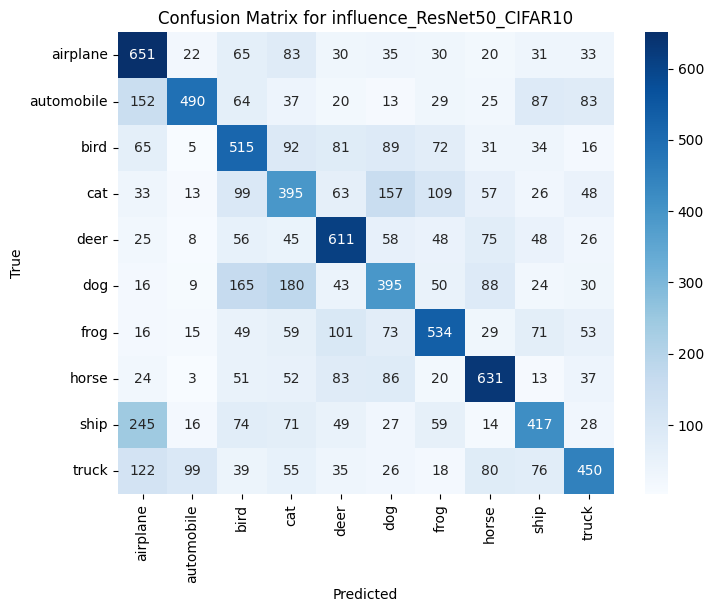

In [411]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
# classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
show_metrics(predictions_path, classes, model_to_unlearn_name)